# Full model with training

In [1]:
import numpy as np
import pandas as pd
import time
import torch
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
data = np.load('data/articles_comb.npy', allow_pickle=True) 

In [4]:
def subsequent_mask(sz):
    '''Masking for decoder'''
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1).float()
    mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir='data/articles_comb.npy', pt_model = 'bert-base-uncased', max_title=50, max_text=75):
        '''
        Args:
        root_dir (string): Path to npy directory
        pt_model (string): Which pre-trained model to use
        
        Outputs:
        title (torch.tensor): indexed input for model
        text (torch.tensor): indexed target for model
        title_mask (torch.tensor): masking for titles
        text_mask (torch.tensor): masking for text
        '''
        self.data = np.load(root_dir, allow_pickle=True) 
        self.tokenizer = BertTokenizer.from_pretrained(pt_model)
        self.max_title = max_title
        self.max_text = max_text
        
    
    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        #load text and title data and tokenize with ready-made tokenizer
        tokenized_title = self.tokenizer(self.data[idx, 0], return_tensors='pt', padding='max_length',truncation=True, max_length=self.max_title)
        tokenized_text = self.tokenizer(self.data[idx, 1], return_tensors='pt', padding='max_length',truncation=True, max_length=self.max_text)
        
        # get indexed text & title
        title = tokenized_title['input_ids']
        text = tokenized_text['input_ids']
        
        # masking for text (+2 in torch.ones comes from adding start and stop tokens)
        title_mask = tokenized_title['attention_mask']
        text_mask = tokenized_text['attention_mask']
        
        #move to device
        title = title.to(device)
        text = text.to(device)
        title_mask = title_mask.to(device)
        text_mask = text_mask.to(device)
        
        return title, text , title_mask, text_mask

In [6]:
class TinyCustomDataset(Dataset):
    def __init__(self, root_dir='data/articles_comb.npy', pt_model = 'bert-base-uncased', max_title=50, max_text=75):
        '''
        Args:
        root_dir (string): Path to npy directory
        pt_model (string): Which pre-trained model to use
        
        Outputs:
        title (torch.tensor): indexed input for model
        text (torch.tensor): indexed target for model
        title_mask (torch.tensor): masking for titles
        text_mask (torch.tensor): masking for text
        '''
        self.data = np.load(root_dir, allow_pickle=True) 
        self.tokenizer = AutoTokenizer.from_pretrained("google/bert_uncased_L-2_H-768_A-12")
        self.max_title = max_title
        self.max_text = max_text
        
    
    def __len__(self):
        return len(self.data) 
    
    def __getitem__(self, idx):
        #load text and title data and tokenize with ready-made tokenizer
        tokenized_title = self.tokenizer(self.data[idx, 0], return_tensors='pt', padding='max_length',truncation=True, max_length=self.max_title)
        tokenized_text = self.tokenizer(self.data[idx, 1], return_tensors='pt', padding='max_length',truncation=True, max_length=self.max_text)
        
        # get indexed text & title
        title = tokenized_title['input_ids']
        text = tokenized_text['input_ids']
        
        # masking for text (+2 in torch.ones comes from adding start and stop tokens)
        title_mask = tokenized_title['attention_mask']
        text_mask = tokenized_text['attention_mask']
        
        #move to device
        title = title.to(device)
        text = text.to(device)
        title_mask = title_mask.to(device)
        text_mask = text_mask.to(device)
        
        return title, text , title_mask, text_mask

In [7]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, num_layers, n_features, n_heads, dropout=0.1):
        """
        Inputs:
            vocab_size : vocabulary size
            num_layers : number of decoder layers
            n_features : word embedding size
            n_heads : number of attention heads
            n_hidden : number of hidden layers
            dropout : dropout level
        """
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, n_features)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=n_features, nhead=n_heads, dropout=dropout)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(n_features, vocab_size)
        self.soft = nn.LogSoftmax(dim=2)

    def forward(self, tgt, memory, src_mask, tgt_mask):
        """
        Inputs:
            tgt : target inputs shape(batch, max_tgt_len)
            memory : encoded inputs
            src_mask : source mask
            tgt_mask : target mask
        """
        tgt = self.embedding(tgt)
        x = self.decoder(tgt, memory, tgt_mask=subsequent_mask(tgt.shape[0]).to(device))
        x = self.linear(x)
        x = self.soft(x)
        
        return x

# Training

In [8]:
start = time.time()
ds = TinyCustomDataset("data/train.npy")
print(time.time()-start)

2.513828992843628


In [9]:
#validation, test, train = torch.utils.data.random_split(ds, [round(len(data)*0.1),round(len(data)*0.2), round(len(data)*0.7)])
#validation, test, train = torch.utils.data.random_split(ds, [14256,28514,99798])

In [9]:
validloader = DataLoader(dataset=ds, batch_size=16, shuffle=True)

In [10]:
tiny = 1

In [11]:
if tiny:
    encoder = AutoModel.from_pretrained("google/bert_uncased_L-2_H-768_A-12").to(device)
else:
    encoder = BertModel.from_pretrained("bert-base-uncased").to(device)

In [12]:
decoder = Decoder(vocab_size=30522, num_layers = 4, n_features = 768, n_heads = 12, dropout=0.1).to(device)

## optimizer

In [13]:
num_epochs = 2

In [14]:
steps = 7129 * num_epochs #total number of batches
warm_up = round(steps/6) # warmup 1/6 th of total batches

In [15]:
encoder_optimizer = AdamW(encoder.parameters(), lr=1e-4)
enc_scheduler = get_linear_schedule_with_warmup(encoder_optimizer, num_warmup_steps = warm_up, num_training_steps = steps)
decoder_optimizer = AdamW(decoder.parameters(), lr=1e-4)
dec_scheduler = get_linear_schedule_with_warmup(decoder_optimizer, num_warmup_steps = warm_up, num_training_steps = steps)

In [16]:
encoder.train()
decoder.train()
criterion = nn.NLLLoss(ignore_index=0)
losses = []
e_losses = []
for e in range(num_epochs):
    start= time.time()
    for i, data in enumerate(validloader):
        #load data and change their dimensions to fit BERT
        targets = data[0].squeeze()
        inputs = data[1].squeeze()
        targets_masks = data[2].squeeze()
        inputs_masks = data[3].squeeze()
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        #encode the inputs using BERT & change dimensions to fit transformer decoder
        encoded_inputs = encoder(inputs, attention_mask=inputs_masks)
        encoded_inputs = encoded_inputs[0].permute(1,0,2)
        
        # Next encoded would go through decoder and then a loss would be calculated
        targets = torch.transpose(targets, 0, 1)
        outputs = decoder(targets[:-1], encoded_inputs, inputs_masks, targets_masks)
        outputs = torch.flatten(outputs, start_dim=0, end_dim=1)
        targets = torch.flatten(targets[1:])
        
        loss = criterion(outputs, targets)
        loss.backward()
        losses.append(loss.item())
        
        encoder_optimizer.step()
        enc_scheduler.step()
        decoder_optimizer.step()
        dec_scheduler.step()
        if i%500==0:
            print(time.time()-start)
            print("Epoch Step: %d Loss: %f" %(i+1, loss.item()))
    
    print(time.time()-start)
    print("Mean loss for epoch: %f" %(np.mean(losses)))
    enc_fname = 'models/FinalEncoderTiny2E'+ str(e+1) +'L4H12LR-4.pth'
    dec_fname = 'models/FinalDecoderTiny2E'+ str(e+1) +'L4H12LR-4.pth'
    torch.save(encoder.state_dict(), enc_fname)
    torch.save(decoder.state_dict(), dec_fname)

0.8969099521636963
Epoch Step: 1 Loss: 10.464056
118.45726799964905
Epoch Step: 501 Loss: 7.137733
235.68254137039185
Epoch Step: 1001 Loss: 6.127175
353.04618096351624
Epoch Step: 1501 Loss: 6.268010
470.3697545528412
Epoch Step: 2001 Loss: 6.154105
587.712338924408
Epoch Step: 2501 Loss: 5.592915
704.5993876457214
Epoch Step: 3001 Loss: 5.332460
821.3190634250641
Epoch Step: 3501 Loss: 5.280485
937.8281919956207
Epoch Step: 4001 Loss: 5.465281
1054.3582355976105
Epoch Step: 4501 Loss: 5.300478
1170.8573195934296
Epoch Step: 5001 Loss: 5.281221
1287.388870716095
Epoch Step: 5501 Loss: 5.144050
1404.091150045395
Epoch Step: 6001 Loss: 4.249664
1520.8257870674133
Epoch Step: 6501 Loss: 4.263848
1637.527836561203
Epoch Step: 7001 Loss: 5.141964
1667.3183591365814
Mean loss for epoch: 5.616300
0.20313215255737305
Epoch Step: 1 Loss: 4.531831
116.90210199356079
Epoch Step: 501 Loss: 4.404940
233.57371068000793
Epoch Step: 1001 Loss: 4.288838
350.2767827510834
Epoch Step: 1501 Loss: 4.49203

In [ ]:
losses = np.array(losses)

In [18]:
np.save('losses/traintiny_sche_lossesE2.npy',losses)

In [19]:
from matplotlib import pyplot as plt

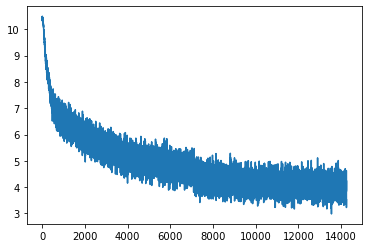

In [20]:
plt.plot(losses)

# Testing the Model

### Generating Titles

In [8]:
encoder = BertModel.from_pretrained("bert-base-uncased").to(device)
encoder.load_state_dict(torch.load('models/FinalEncoder2E2L4H12LR-4.pth', map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [9]:
decoder = Decoder(vocab_size=30522, num_layers = 4, n_features = 768, n_heads = 12, dropout=0.1).to(device)
decoder.load_state_dict(torch.load('models/FinalDecoder2E2L4H12LR-4.pth', map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [10]:
start = time.time()
ds = CustomDataset("data/test.npy")
print(time.time()-start)

1.9477717876434326


In [11]:
ValidTestLoader = DataLoader(dataset=ds, batch_size=1, shuffle=True)

In [12]:
def generate_title(encoder, decoder, src_seq, inputs_masks, targets_masks):
    """
    Args:
      encoder (Encoder): Trained encoder.
      decoder (Decoder): Trained decoder.
      src_seq of shape (src_seq_length): LongTensor of word indices of the source sentence.
    
    Returns:
      out_seq of shape (out_seq_length, 1): LongTensor of word indices of the output sentence.
    """
    # YOUR CODE HERE
    eout = encoder(src_seq, attention_mask=inputs_masks)
    eout = eout[0].permute(1,0,2)
    output= torch.zeros(1, 1).fill_(101).type_as(src_seq)
    for i in range(50):
        if output[i]==102:
            break
        dout = decoder(output, eout, inputs_masks, targets_masks)
        #estimate list of word indexes based on decoder output
        next_word_idx = dout.max(2)[1].squeeze(1)
        output = torch.cat([output, torch.ones(1,1).type_as(output).fill_(next_word_idx[-1])], dim=0)
    return output

In [13]:
def remove_extra_tokens(seq):
    pad = ['[PAD]', '[CLS]','[SEP]']
    seq = seq.split()

    seq  = [word for word in seq if word not in pad]
    seq = ' '.join(seq)
    
    return seq

In [14]:
def generate_and_BLEU(encoder, decoder, data, dataset):
    '''
    encoder: BERT model
    decoder: Transformer model
    data: list of targets, inputs, target_masks, input_masks
    dataset: Custom dataset that contains the tokenizer to get the vocabulary
    '''
    src_seq = data[1].squeeze(dim=1)
    target_seq = dataset.tokenizer.decode(data[0].squeeze()) #transform it to text
    target_seq = remove_extra_tokens(target_seq) #remove pads
    inputs_masks = data[3]
    targets_masks = data[2]
    
    #generate title
    generated_title = generate_title(encoder, decoder, src_seq, inputs_masks, targets_masks)
    
    #transform generated to text
    src_seq = dataset.tokenizer.decode(generated_title.T.squeeze()) 
    src_seq = remove_extra_tokens(src_seq)
    
    #calculate BLEU
    bleu = sentence_bleu([target_seq], src_seq)
    
    return bleu, src_seq, target_seq

In [43]:
'''encoder.eval()
decoder.eval()
bleus = []
start = time.time()
with torch.no_grad():
    for i, data_list in enumerate(ValidTestLoader):
        bleu, src_seq, target_seq = generate_and_BLEU(encoder, decoder, data_list, ds)
        bleus.append(bleu)
        if i%2000 ==0:
            print(i)
            print(time.time()-start)
            print(src_seq)
            print(target_seq)'''

0
0.18015599250793457
here ’ s how to get your job to get your job
23 questions you should never ask at the end of a job interview


E:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
E:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
E:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


2000
272.2538573741913
obama ’ s $ 1. 5 billion deal with $ 1 billion in the wall street
when will obama have made enough money?
4000
544.1833250522614
the white house is a new threat to the white house
republicans and democrats are both wrong about leaks from intelligence agencies
6000
817.3101925849915
pentagon : us to fight isis in mosul
pentagon mulls more troops to fight isis in iraq
8000
1093.8131906986237
donald trump ’ s pick for vp pick is a big problem
trump is doing something no candidate has done in almost 30 years, and it could pay off
10000
1363.8259599208832
a new book of the world ’ s most powerful story
’ glory of the world ’ is more wacky birthday party than traditional play
12000
1631.4416756629944
the mystery of the seaworld is dead
why killer whales ( and humans ) go through menopause
14000
1899.6606404781342
google ’ s self - driving uber is a new way to be a new job
hell of a ride : even a pr powerhouse couldn ’ t get uber on track
16000
2176.083243370056
los ang

In [44]:
#np.mean(bleus)

0.2333676567115117

In [15]:
encoder.eval()
decoder.eval()
bleus = []
start = time.time()
with torch.no_grad():
    for i, data_list in enumerate(ValidTestLoader):
        bleu, gen_seq, target_seq = generate_and_BLEU(encoder, decoder, data_list, ds)
        
        print("Generation num: %d" %(i+1))
        print('Generated title:')
        print(gen_seq)
        print(' ')
        print('Original title:')
        print(target_seq)
        print(' ')
        print('Input sequence:')
        print(ds.tokenizer.decode(data_list[1].squeeze()))
        print(' ')
        if i ==14:
            break

Generation num: 1
Generated title:
ryan lochte ’ s twitter account
 
Original title:
ryan lochte ’ s sponsorship woes
 
Input sequence:
[CLS] for us to continue writing great stories, we need to display ads. please select the extension that is blocking ads. please follow the steps below, updated on august 22 at 5 : 11 p. m. est, news brief ryan lochte, the olympic swimmer, has lost four major commercial sponsorships over his account [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
 
Generation num: 2
Generated title:
putin meets with trump, obama ’ s speech
 
Original title:
putin congratulates trump in new year statement
 
Input sequence:
[CLS] ( cnn ) russian president vladimir putin congratulated us donald trump, rather than president barack obama, in his annual new year ’ s greetings statement to foreign heads of state and government. however, putin did convey his seasonal greetings to obama, his family and the american people in a separate statement earlier friday

E:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


[CLS] “ our government ’ s become pretty good at detecting and preventing something hatched from overseas, ” johnson told “ fox news sunday ” from the world trade center memorial in new york city. “ we ’ re better than we were 15 years ago. where we ’ re challenged, however, is the lone attack. ” nearly 3, 000 people were [SEP] [PAD] [PAD] [PAD] [PAD]
 
Generation num: 6
Generated title:
obama ’ s immigration ban gets jail for illegal immigrants
 
Original title:
white house ‘ champion of change ’ sentenced for immigration fraud - breitbart
 
Input sequence:
[CLS] an immigration activist the obama white house once honored as a “ champion of change ” embodying “ the spirit of cesar chavez ’ s legacy ” has been sentenced to probation for her role in deceiving immigration authorities on behalf of a foreign national. [ bonnie monique youn, an immigration lawyer, was sentenced last week to [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
 
Generation num: 7
Generated title:
tillerson :

E:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Generation num: 14
Generated title:
egyptair flight after egyptair flight, egyptair flight - the new york times
 
Original title:
security forces arrest egyptair hijacker after airport standoff in cyprus
 
Input sequence:
[CLS] cairo — a nearly hijacking standoff in cyprus ended tuesday after the surrender of a man who commandeered an egyptian airliner, claiming to have an explosive vest, officials said. there were no immediate reports of injuries among the more than 55 passengers and crew on the egyptair flight, and cypriot [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
 
Generation num: 15
Generated title:
the fed ’ s treasury secretary of interest rates
 
Original title:
comptroller of the currency gig probably the easiest in dc
 
Input sequence:
[CLS] keith noreika, the acting comptroller of the currency, might have the easiest job in washington. picked in may as the interim regulator of banks, noreika has had to recuse himself from overseeing 80 bank

In [ ]:
# check tiny

In [16]:
encoder = AutoModel.from_pretrained("google/bert_uncased_L-2_H-768_A-12").to(device)
encoder.load_state_dict(torch.load('models/FinalEncoderTiny2E2L4H12LR-4.pth', map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [17]:
decoder = Decoder(vocab_size=30522, num_layers = 4, n_features = 768, n_heads = 12, dropout=0.1).to(device)
decoder.load_state_dict(torch.load('models/FinalDecoderTiny2E2L4H12LR-4.pth', map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [18]:
start = time.time()
ds = TinyCustomDataset("data/test.npy")
print(time.time()-start)

ValidTestLoader = DataLoader(dataset=ds, batch_size=1, shuffle=True)

2.369154453277588


In [19]:
encoder.eval()
decoder.eval()
bleus = []
start = time.time()
with torch.no_grad():
    for i, data_list in enumerate(ValidTestLoader):
        bleu, gen_seq, target_seq = generate_and_BLEU(encoder, decoder, data_list, ds)
        
        print("Generation num: %d" %(i+1))
        print('Generated title:')
        print(gen_seq)
        print(' ')
        print('Original title:')
        print(target_seq)
        print(' ')
        print('Input sequence:')
        print(ds.tokenizer.decode(data_list[1].squeeze()))
        print(' ')
        if i ==14:
            break

Generation num: 1
Generated title:
the ceo of the ceo of the company ’ s ceos
 
Original title:
yay, it ’ s time for my performance review! ( said no one ever )
 
Input sequence:
[CLS] it ’ s once again time for the annual ritual of fear and loathing, also known as the performance review — at least for the companies that still do them. many have abandoned the old way of evaluating their employees in recent years. last year, even general electric — whose former ceo [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
 
Generation num: 2
Generated title:
in poland, a new york city, a new year - the new york times
 
Original title:
this is what happens to women ’ s rights when the far right takes over
 
Input sequence:
[CLS] warsaw, poland — it was the first monday in october, which is to say that it was gray, and gross. so they brought umbrellas. not just in warsaw. in katowice, lodz, gdansk, and krakow, and tiny villages between. so many 